# Computer Vision

Before I start coding here are some important computer vision libraries
<table>
    <thead>Pytorch module
        <tr>
            <th>Pytorch Module</th>
            <th>What does it do?</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td> Torchvision </td>
            <td> Constains datasets, models, transformations used in computervision</td>
        </tr>
        <tr>
            <td> torchvision.datasets </td>
            <td> Constains datasets that can be loaded like FashionMnist. also contains base classes to make custom datasets</td>
        </tr>
        <tr>
            <td> torchvision.models </td>
            <td> Constains pretrained models and architectures that can be used</td>
        </tr>
        <tr>
            <td> torchvision.trasnformations </td>
            <td> Constains a series of transformations that can be used on images and videos</td>
        </tr>
        <tr>
            <td> torch.utils.data.Dataset </td>
            <td> Base class for dataset</td>
        </tr>
        <tr>
            <td> torch.utils.data.DataLoader </td>
            <td> Creates python iterable over dataset</td>
        </tr>
    </tbody>

</table>

In [1]:
# imports
import torch
import torch.nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor 
from torch.utils.data import DataLoader

# plotting
import matplotlib.pyplot as plt

In [2]:
# getting a dataset (Fashion Mnist)
train_data = datasets.FashionMNIST(
    root='data', # where to download the data
    train=True,  # True = get training data
    download=True, # should the data be downloaded?
    transform=torchvision.transforms.ToTensor(), # Image comes as PIL format, we want to transform it to a tensor
    target_transform=None # how do we transform the targets? labels can be transformed as well
    )

test_data = datasets.FashionMNIST(
    root='data', 
    train=False,  # False = get Test data
    download=True,  
    transform=torchvision.transforms.ToTensor(), 
    target_transform=None 
    )

In [3]:
# storing class names and indices.
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
image, label = train_data[0] # image shape (1,28,28)


# Visualise the dataset

* Use plt.imshow to visualise the data.
* Matplot lib expects only 2 dimensions (h,w) or it expects (h,w,c) with color channels being last.

Text(0.5, 1.0, 'Ankle boot')

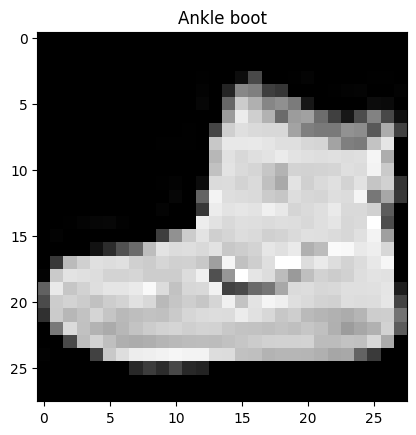

In [4]:
# squeeze the image to remove the 1st dimension. This leaves with just (h,w)
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])

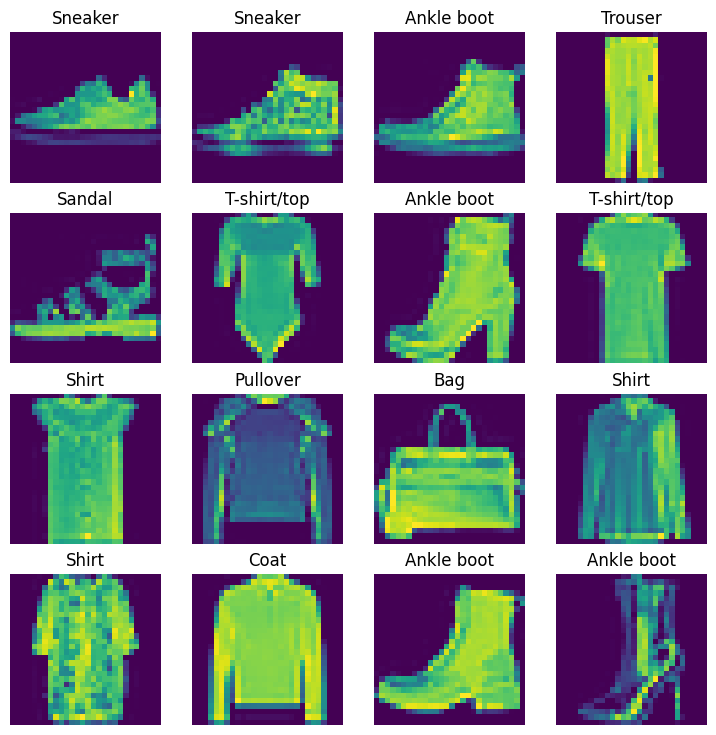

In [5]:
fig = plt.figure(figsize=(9,9))
rows,cols = 4,4
for i in range (1, rows*cols+1):
    random_indx = torch.randint(0,len(train_data), size=[1]).item()
    image,label = train_data[random_indx]
    fig.add_subplot(rows,cols, i)
    plt.imshow(image.squeeze())
    plt.title(class_names[label])
    plt.axis(False)

# Put the data into Dataloader to make it python iterable

In [6]:
# turn datasets into data loaders
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

# check the shape of the dataloaders
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

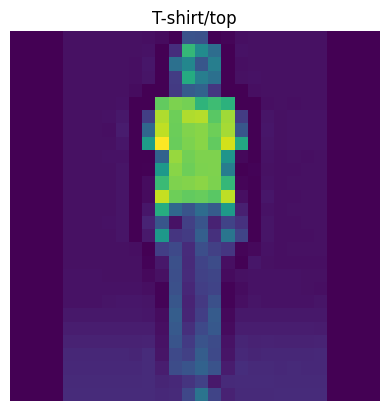

In [7]:
# let's visualise the data in the this batch
indexs = torch.randint(0,len(train_features_batch), size=[1]).item()
image, label = train_features_batch[indexs], train_labels_batch[indexs]
plt.imshow(image.squeeze())
plt.title(class_names[label.item()])
plt.axis(False);

# Build Baseline model

**Shape before flattening:** torch.Size([1, 28, 28]) -> [color_channels, height, width] <br/>
**Shape after flattening:** torch.Size([1, 784]) -> [color_channels, height*width] <br/>

The nn.Flatten() layer took our shape from [color_channels, height, width] to [color_channels, height*width].

Why do this?

Because we've now turned our pixel data from height and width dimensions into one long feature vector.

And nn.Linear() layers like their inputs to be in the form of feature vectors


In [8]:
class FashionMNISTModelV0(torch.nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = torch.nn.Sequential(
            torch.nn.Flatten(), # neural networks like their inputs in vector form
            torch.nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            torch.nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [9]:
# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, # one for every pixel (28x28)
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(class_names) # one for every class
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [10]:
# Get helper functions for plotting
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [11]:
def acuracy(y_true, y_pred):
    acc = ((torch.eq(y_true,y_pred).sum().item())/len(y_pred))*100
    return acc


### Training and Testing Loop 
A batch is BATCH_SIZE samples of X (features) and y (labels), since I'm using BATCH_SIZE=32, my batches have 32 samples of images and targets.

And since I'm computing on batches of data, my loss and evaluation metrics will be calculated per batch rather than across the whole dataset.

This means I'll have to divide the loss and accuracy values by the number of batches in each dataset's respective dataloader.

Let's step through it:<br/>
<ul>
<li>Loop through epochs.</li>
<li>Loop through training batches, perform training steps, calculate the train loss per batch.</li>
<li>Loop through testing batches, perform testing steps, calculate the test loss per batch.</li>
<li>Print out what's happening.</li>
<li>Time it all (for fun).</li>

### One Important Note:
Question that I posted: https://github.com/mrdbourke/pytorch-deep-learning/discussions/310</br>
Answer thread : https://github.com/mrdbourke/pytorch-deep-learning/discussions/314
<p>
Softmax not used below. Im directly going from logits - > preds and not logits - > pred probabilities - > preds why?</br>
Softmax is a monotonous function. It doesn't change the order of the inputs that go into it, only the value is changed. It leads to change of values to range between 0 and 1 and all values adding to 1.
</p>

In [12]:
from tqdm.auto import tqdm

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_loss, train_acc = 0, 0
    ## Training
    for batch, (X,y) in enumerate(train_dataloader):
        model_0.train()

        # Forward Pass
        y_train_logits = model_0.forward(X)

        # Get the predictions
        y_train_pred = torch.argmax(y_train_logits, dim=1)

        # Calculate the train loss and accuracy. Here loss is split becasuse we need to do backward pass on the loss and not accumulated loss
        loss = loss_fn(y_train_logits, y)
        train_loss += loss
        train_acc += acuracy(y,y_train_pred)

        # Set the optimizer to zero_grad()
        optimizer.zero_grad()

        # Calculate the loss backward
        loss.backward()

        # Optimizer Step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)



    ## Testing
    test_loss, test_acc = 0, 0

    model_0.eval()
    with torch.inference_mode():
        for batch, (X,y) in enumerate(test_dataloader):
            # Forward pass
            y_test_logits = model_0.forward(X)

            # Convert to predictions
            y_test_pred = torch.argmax(y_test_logits, dim=1)

            # Calculate Loss and Accuracy.
            test_loss += loss_fn(y_test_logits, y)
            test_acc += acuracy(y, y_test_pred)

        # Divide total train loss by length of train dataloader (average loss per batch per epoch)
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:07<00:14,  7.35s/it]


Train loss: 0.59279 | Train Acc: 78.75% | Test loss: 0.53188, Test acc: 80.27%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:16<00:08,  8.12s/it]


Train loss: 0.47436 | Train Acc: 83.31% | Test loss: 0.49563, Test acc: 82.10%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:27<00:00,  9.24s/it]


Train loss: 0.45423 | Train Acc: 84.15% | Test loss: 0.48329, Test acc: 82.66%



## Create Non-Linear and Convolution Models

In [13]:
# Make functions to train, test and evaluate a model. This is because we will be making 2 more models and would not like to repeat writing the same code.
def model_train(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer:torch.optim.Optimizer, acuracy):
    train_loss, train_acc = 0, 0
    for batch, (X,y) in enumerate(data_loader):
        model.train()

        y_train_logits = model(X)

        y_train_pred = torch.argmax(y_train_logits, dim=1)

        loss = loss_fn(y_train_logits, y)
        train_loss += loss
        train_acc += acuracy(y,y_train_pred)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def model_test(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, acuracy):
    test_loss, test_acc = 0,0
    model.eval()
    for batch, (X,y) in enumerate(data_loader):
        y_test_logits = model(X)

        y_test_pred = torch.argmax(y_test_logits, dim=1)

        test_loss += loss_fn(y_test_logits, y)
        test_acc += acuracy(y,y_test_pred)

    
    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

def model_eval(model: torch.nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn:torch.nn.Module, accuracy):

    loss , acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X,y) in enumerate(data_loader):
            y_logits = model(X)

            y_pred = torch.argmax(y_logits, dim=1)

            loss += loss_fn(y_logits, y)
            acc += accuracy(y, y_pred)

        loss /= len(data_loader)
        acc /= len(data_loader)


    return {
        "model_name": model.__class__.__name__, # only works when model was created with a class
        "model_loss": loss.item(),
        "model_acc": acc
    }


# calculate model 0 returns on test dataset
model_0_results = model_eval(model_0, test_dataloader, loss_fn, acuracy)


model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.48267897963523865,
 'model_acc': 82.67771565495208}

#### Non-Linear Model

In [14]:
class FashionMNISTModelV1(torch.nn.Module):
    def __init__(self, input_shape:int, output_shape:int, hidden_units:int) -> None:
        super().__init__()
        self.layer_stack = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=input_shape, out_features=hidden_units),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=hidden_units, out_features=output_shape),
            torch.nn.ReLU()

        )
    def forward(self, x):
        return self.layer_stack(x)
    
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, output_shape=len(class_names), hidden_units=10)
loss_fn_1 = torch.nn.CrossEntropyLoss()
optimizer_1 = torch.optim.SGD(params=model_1.parameters(), lr = 0.1)

In [15]:
epochs = 3

for epoch in tqdm(range(epochs)):
    model_train(model=model_1, data_loader=train_dataloader, loss_fn=loss_fn_1, optimizer=optimizer_1, acuracy=acuracy)
    
    model_test(model=model_1, data_loader=test_dataloader, loss_fn=loss_fn_1, acuracy=acuracy)
    

  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 1.05878 | Train accuracy: 62.19%


 33%|███▎      | 1/3 [00:20<00:40, 20.48s/it]

Test loss: 0.99613 | Test accuracy: 64.09%

Train loss: 0.91179 | Train accuracy: 66.32%


 67%|██████▋   | 2/3 [00:44<00:22, 22.50s/it]

Test loss: 0.95756 | Test accuracy: 65.47%

Train loss: 0.88172 | Train accuracy: 67.25%


100%|██████████| 3/3 [01:01<00:00, 20.64s/it]

Test loss: 0.89043 | Test accuracy: 67.08%



In [16]:
# Calculate model 0 results on test dataset
model_1_results = model_eval(model_1, test_dataloader, loss_fn_1, acuracy)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.8926109075546265,
 'model_acc': 67.00279552715655}

### 